---------------- 23/07/2024 ----------------------------
The code implements parts of the experiment described in the paper "Shared Autonomy via Deep Reinforcement Learning" by Siddharth Reddy, Anca D. Dragan, and Sergey Levine. This paper introduces a model-free shared autonomy framework using deep reinforcement learning (DRL) to assist human users in real-time control tasks.


Imports and Directory Setup:

- Imports necessary libraries
- Creates a directory to save data related to the Lunar Lander simulation

In [1]:
import gym
import numpy as np
from gym import spaces
from gym.wrappers import TimeLimit
from gym.wrappers import RecordVideo
import types
from copy import deepcopy
import os
import pickle
from collections import Counter
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from stable_baselines3.common.policies import BasePolicy
from stable_baselines3.common.utils import set_random_seed

from stable_baselines3.common.utils import polyak_update
from stable_baselines3.common.vec_env import DummyVecEnv

# Directory for saving data
data_dir = os.path.join('data', 'lunarlander-sim')
os.makedirs(data_dir, exist_ok=True)

 Environment Setup: Prepares the custom environment by defining the action and observation spaces, wrapping the environment to adapt to the new API, and implementing a function to convert discrete actions to continuous ones. This is essential for the Lunar Lander game used in the simulation experiments in the paper.

In [3]:
# Custom environment setup
throttle_mag = 0.75
discrete_actions = [
    [-throttle_mag, -throttle_mag], [-throttle_mag, 0], [-throttle_mag, throttle_mag],
    [throttle_mag, -throttle_mag], [throttle_mag, 0], [throttle_mag, throttle_mag]
]
n_act_dim = len(discrete_actions)
n_obs_dim = 8

def disc_to_cont(action):
    return np.array(discrete_actions[action])

def mask_helipad(obs, replace=0):
    obs = deepcopy(obs)
    if len(obs.shape) == 1:
        if len(obs) >= 9: 
            obs[8] = replace
    else:
        if obs.shape[1] >= 9:  
            obs[:, 8] = replace
    return obs

def traj_mask_helipad(traj):
    return [mask_helipad(obs) for obs in traj]

class OldStepAPIWrapper(gym.Wrapper):
    def step(self, action):
        result = self.env.step(action)
        if len(result) == 4:  # Old Gym API: (obs, reward, done, info)
            obs, reward, done, info = result
            terminated = done
            truncated = False
        elif len(result) == 5:  # New Gym API: (obs, reward, terminated, truncated, info)
            obs, reward, terminated, truncated, info = result
        else:
            raise ValueError(f"Unexpected number of values returned by step method: {len(result)}")
        return obs, reward, terminated, truncated, info

    def reset(self, **kwargs):
        result = self.env.reset(**kwargs)
        if isinstance(result, tuple):
            return result  # New API (obs, info)
        else:
            return result, {}  # Old API obs, empty info dictionary

class DiscretizedActionWrapper(gym.ActionWrapper):
    def __init__(self, env, action_map):
        super().__init__(env)
        self.action_map = action_map
        self.action_space = spaces.Discrete(len(action_map))

    def action(self, action):
        return self.action_map[action]


class AugmentedObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super(AugmentedObservationWrapper, self).__init__(env)
        low = np.append(self.env.observation_space.low, -1.0)
        high = np.append(self.env.observation_space.high, 1.0)
        self.observation_space = spaces.Box(low=low, high=high, dtype=np.float32)

    def observation(self, observation):
        # Compute the additional observation feature if needed
        augmented_observation = np.append(observation, 0.0)  # Replace 0.0 with actual computation
        return augmented_observation
 
def make_env(using_lander_reward_shaping=False):
    env = gym.make('LunarLanderContinuous-v2')
    env = OldStepAPIWrapper(env)  # Apply the wrapper to adapt to new API
    env = DiscretizedActionWrapper(env, discrete_actions)
    env = AugmentedObservationWrapper(env)  # Add augmented observation
    env.unwrapped.using_lander_reward_shaping = using_lander_reward_shaping
    return env

env = make_env(using_lander_reward_shaping=True)
env = TimeLimit(env, max_episode_steps=1000)  # Ensure TimeLimit wrapper is applied


DQN Model Training:

- Custom Callback: Defines a callback class RewardCallback to keep track of rewards during training.
- DQN Model Definition: Specifies the training parameters for the DQN model, including learning rate, exploration parameters, and target update interval.
- Model Training: Trains the DQN model using the defined parameters and saves the model and reward data. This training is part of the human-in-the-loop deep Q-learning described in the paper.

In [4]:
# Custom callback to track training progress
class SuccessCrashRewardCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(SuccessCrashRewardCallback, self).__init__(verbose)
        self.success_rates = []
        self.crash_rates = []
        self.episode_rewards = []
        self.current_rewards = []
        self.success_count = 0
        self.crash_count = 0
        self.total_episodes = 0
        self.SUCCESS_THRESHOLD = 100
        self.CRASH_THRESHOLD = -100

    def _on_step(self) -> bool:
        reward = self.locals['rewards'][0]
        done = self.locals['dones'][0]
        self.current_rewards.append(reward)
        
        if done:
            episode_reward = sum(self.current_rewards)
            self.current_rewards = []
            self.total_episodes += 1
            self.episode_rewards.append(episode_reward)

            if episode_reward >= self.SUCCESS_THRESHOLD:
                self.success_count += 1
            if episode_reward <= self.CRASH_THRESHOLD:
                self.crash_count += 1

            success_rate = self.success_count / self.total_episodes
            crash_rate = self.crash_count / self.total_episodes

            self.success_rates.append(success_rate)
            self.crash_rates.append(crash_rate)

            print(f"Episode {self.total_episodes}: Reward: {episode_reward}, Success Rate: {success_rate}, Crash Rate: {crash_rate}")

        return True


In [5]:

# Training parameters
max_ep_len = 1000
n_training_episodes = 500
pilot_dqn_learn_kwargs = {
    'learning_rate': 1e-3,
    'exploration_fraction': 0.1,
    'exploration_final_eps': 0.02,
    'print_freq': 100,
    'gamma': 0.99
}

# Define the scope for the model
full_pilot_scope = 'full_pilot'
load_pretrained_full_pilot = False  # Training from scratch

# Create and/or load the DQN model
model = DQN("MlpPolicy", env, verbose=1, tensorboard_log="./logs/",
            policy_kwargs=dict(activation_fn=nn.ReLU, net_arch=[64, 64]),
            learning_rate=pilot_dqn_learn_kwargs['learning_rate'],
            exploration_fraction=pilot_dqn_learn_kwargs['exploration_fraction'],
            exploration_final_eps=pilot_dqn_learn_kwargs['exploration_final_eps'],
            target_update_interval=1500,
            gamma=pilot_dqn_learn_kwargs['gamma'])

callback = SuccessCrashRewardCallback()

# Train the model
model.learn(total_timesteps=max_ep_len * n_training_episodes,
            log_interval=pilot_dqn_learn_kwargs['print_freq'],
            callback=callback)

# Save the model
model.save("full_pilot_model")

# Save the reward data
full_pilot_reward_data = callback.episode_rewards
with open(os.path.join(data_dir, 'full_pilot_reward_data.pkl'), 'wb') as f:
    pickle.dump(full_pilot_reward_data, f, pickle.HIGHEST_PROTOCOL)

# Load the reward data if needed
with open(os.path.join(data_dir, 'full_pilot_reward_data.pkl'), 'rb') as f:
    full_pilot_reward_data = pickle.load(f)

full_pilot_success_rate = callback.success_rates
with open(os.path.join(data_dir, 'full_pilot_success_rate.pkl'), 'wb') as f:
    pickle.dump(full_pilot_success_rate, f, pickle.HIGHEST_PROTOCOL)

with open(os.path.join(data_dir, 'full_pilot_success_rate.pkl'), 'rb') as f:
    full_pilot_success_rate = pickle.load(f)

full_pilot_crash_rate = callback.crash_rates

with open(os.path.join(data_dir, 'full_pilot_crash_rate.pkl'), 'wb') as f:
    pickle.dump(full_pilot_crash_rate, f, pickle.HIGHEST_PROTOCOL)

with open(os.path.join(data_dir, 'full_pilot_crash_rate.pkl'), 'rb') as f:
    full_pilot_crash_rate = pickle.load(f)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/home/estelle-gerbier/Scrivania/COMET/myenv/lib/python3.12/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Logging to ./logs/DQN_207
Episode 1: Reward: -411.55558219738305, Success Rate: 0.0, Crash Rate: 1.0


/home/estelle-gerbier/Scrivania/COMET/myenv/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 2: Reward: -108.22455323860049, Success Rate: 0.0, Crash Rate: 1.0
Episode 3: Reward: -283.97112677199766, Success Rate: 0.0, Crash Rate: 1.0
Episode 4: Reward: -265.78167760325596, Success Rate: 0.0, Crash Rate: 1.0
Episode 5: Reward: -350.20544826611876, Success Rate: 0.0, Crash Rate: 1.0
Episode 6: Reward: -265.6404701597057, Success Rate: 0.0, Crash Rate: 1.0
Episode 7: Reward: -197.516967585776, Success Rate: 0.0, Crash Rate: 1.0
Episode 8: Reward: -461.0061886757612, Success Rate: 0.0, Crash Rate: 1.0
Episode 9: Reward: -341.0405454323627, Success Rate: 0.0, Crash Rate: 1.0
Episode 10: Reward: -220.16535703185946, Success Rate: 0.0, Crash Rate: 1.0
Episode 11: Reward: -487.4010305533884, Success Rate: 0.0, Crash Rate: 1.0
Episode 12: Reward: -414.3761584972963, Success Rate: 0.0, Crash Rate: 1.0
Episode 13: Reward: -338.0019999630749, Success Rate: 0.0, Crash Rate: 1.0
Episode 14: Reward: -130.7398027162999, Success Rate: 0.0, Crash Rate: 1.0
Episode 15: Reward: -358.6263

Policy Definition:

- FullPilotPolicy, LaggyPilotPolicy, NoisyPilotPolicy, NoopPilotPolicy, SensorPilotPolicy: Implements various pilot policies, including a fully trained policy and several synthetic suboptimal pilots. These pilots correspond to the simulated users described in the simulation experiments section of the paper.

In [6]:
# Define the custom policies
class FullPilotPolicy:
    def __init__(self, model):
        self.model = model

    def __call__(self, obs):
        action, _ = self.model.predict(obs, deterministic=True)
        return int(action)

class LaggyPilotPolicy:
    def __init__(self, full_pilot_policy, lag_prob=0.85):
        self.full_pilot_policy = full_pilot_policy
        self.lag_prob = lag_prob
        self.last_action = None
    
    def __call__(self, obs):
        if self.last_action is None or np.random.random() >= self.lag_prob:
            self.last_action = self.full_pilot_policy(obs)
        return self.last_action

# Initialize the policies using the trained model
full_pilot_policy = FullPilotPolicy(model)
laggy_pilot_policy = LaggyPilotPolicy(full_pilot_policy)



def noisy_pilot_policy(obs, epsilon=0.3):
    action = full_pilot_policy(obs)
    if np.random.random() < epsilon:
        action = np.random.randint(0, 6)  # Assuming there are 6 possible actions
    return action

def noop_pilot_policy(obs):
  return 1


def sensor_pilot_policy(obs, thresh=0.1):
  d = obs[8]-obs[0] # horizontal dist to helipad
  if d < -thresh:
    return 0
  elif d > thresh:
    return 2
  else:
    return 1
  

In [7]:
# Run episodes with the custom policies
def run_ep(policy, env, max_ep_len=max_ep_len, render=False):
    obs, info = env.reset()
    total_reward = 0
    trajectory = []
    actions = []
    success_threshold = 100
    crash_threshold = -100
    success_count = 0
    crash_count = 0

    for step_idx in range(max_ep_len):
        
        action = policy(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        actions.append(action)
        trajectory.append(obs)
        total_reward += reward

      
        if render:
            env.render()
        if terminated or truncated:
            break
            

    if total_reward >= success_threshold:
        success_count += 1
    if total_reward <= crash_threshold:
        crash_count += 1
    return  total_reward, trajectory, actions, success_count, crash_count


In [7]:

# Evaluate synthetic pilots
pilot_names = ['full', 'laggy', 'noisy', 'noop', 'sensor']
n_eval_eps = 100
n_train_eps=500

In [ ]:
import gym
import os
import pickle
import numpy as np
from gym.wrappers import TimeLimit
from stable_baselines3.common.utils import set_random_seed

# Ensure directories exist
data_dir = os.path.join('data', 'lunarlander-sim')
os.makedirs(data_dir, exist_ok=True)

# Helper function to create environment
def make_env(using_lander_reward_shaping=False, seed=None):
    env = gym.make('LunarLanderContinuous-v2')
    env = OldStepAPIWrapper(env)  # Apply the wrapper to adapt to new API
    env = DiscretizedActionWrapper(env, discrete_actions)
    env = AugmentedObservationWrapper(env)  # Add augmented observation
    env.unwrapped.using_lander_reward_shaping = using_lander_reward_shaping
    if seed is not None:
        set_random_seed(seed)
        if hasattr(env, 'seed'):
            env.seed(seed)
        if hasattr(env.action_space, 'seed'):
            env.action_space.seed(seed)
            'ciao'
        if hasattr(env.observation_space, 'seed'):
            env.observation_space.seed(seed)
            'ccciao'
    return env

# Run episodes with the custom policies
def run_ep(policy, env, max_ep_len=1000):
    obs, info = env.reset()
    total_reward = 0
    trajectory = []
    actions = []
    success_threshold = 100
    crash_threshold = -100
    success_count = 0
    crash_count = 0

    for step_idx in range(max_ep_len):
        action = policy(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        actions.append(action)
        trajectory.append(obs)
        total_reward += reward
        
        if terminated or truncated:
            break

    if total_reward >= success_threshold:
        success_count += 1
    if total_reward <= crash_threshold:
        crash_count += 1

    return total_reward, trajectory, actions, success_count, crash_count

# Evaluate synthetic pilots
pilot_names = ['full', 'laggy', 'noisy', 'sensor']

n_eval_eps = 500
n_train_eps = 500  # Number of training episodes
n_runs = 10  # Number of different runs

# Create placeholder for results
pilot_policies = {
    'full': full_pilot_policy,
    'laggy': laggy_pilot_policy,
    'noisy': noisy_pilot_policy,
    'sensor': sensor_pilot_policy
}

# To store results of multiple runs
all_results = {pilot_name: {'rewards': np.zeros((n_runs, n_train_eps)), 
                            'successes': np.zeros((n_runs, n_train_eps)), 
                            'crashes': np.zeros((n_runs, n_train_eps))} for pilot_name in pilot_names}

for run in range(n_runs):
    seed = np.random.randint(0, 10000)  # Different seed for each run
    pilot_evals = {}

    for pilot_name in pilot_names:
        print(f"Evaluating {pilot_name} pilot on run {run + 1} with seed {seed}...")
        rewards = []
        trajectories = []
        actions_list = []
        successes = []
        crashes = []

        for episode in range(n_train_eps):
            env = make_env(using_lander_reward_shaping=True, seed=seed)
            env = TimeLimit(env, max_episode_steps=1000)
            total_reward, trajectory, actions, success_count, crash_count = run_ep(pilot_policies[pilot_name], env)
            
            rewards.append(total_reward)
            trajectories.append(trajectory)
            actions_list.append(actions)
            successes.append(success_count)
            crashes.append(crash_count)

            env.close()

            # Collect results for this episode
            all_results[pilot_name]['rewards'][run, episode] = total_reward
            all_results[pilot_name]['successes'][run, episode] = success_count
            all_results[pilot_name]['crashes'][run, episode] = crash_count

# Calculate mean and standard deviation for the last 100 episodes for each run and then across all runs
for pilot_name in pilot_names:
    run_rewards_last_100 = []
    run_successes_last_100 = []
    run_crashes_last_100 = []

    for run in range(n_runs):
        rewards_last_100 = all_results[pilot_name]['rewards'][run, -100:]
        successes_last_100 = all_results[pilot_name]['successes'][run, -100:]
        crashes_last_100 = all_results[pilot_name]['crashes'][run, -100:]

        run_rewards_last_100.append(np.mean(rewards_last_100))
        run_successes_last_100.append(np.mean(successes_last_100))
        run_crashes_last_100.append(np.mean(crashes_last_100))

    mean_reward = np.mean(run_rewards_last_100)
    std_reward = np.std(run_rewards_last_100)
    mean_success_rate = np.mean(run_successes_last_100)
    std_success_rate = np.std(run_successes_last_100)
    mean_crash_rate = np.mean(run_crashes_last_100)
    std_crash_rate = np.std(run_crashes_last_100)

    print(f"{pilot_name}: Mean Reward (last 100 episodes of all runs) = {mean_reward} ± {std_reward}, "
          f"Success Rate (last 100 episodes of all runs) = {mean_success_rate} ± {std_success_rate}, "
          f"Crash Rate (last 100 episodes of all runs) = {mean_crash_rate} ± {std_crash_rate}")


Evaluating full pilot on run 1 with seed 5020...


/home/estelle-gerbier/Scrivania/COMET/myenv/lib/python3.12/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/estelle-gerbier/Scrivania/COMET/myenv/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Evaluating laggy pilot on run 1 with seed 5020...
Evaluating noisy pilot on run 1 with seed 5020...
Evaluating sensor pilot on run 1 with seed 5020...
Evaluating full pilot on run 2 with seed 1559...
Evaluating laggy pilot on run 2 with seed 1559...
Evaluating noisy pilot on run 2 with seed 1559...
Evaluating sensor pilot on run 2 with seed 1559...
Evaluating full pilot on run 3 with seed 2425...
Evaluating laggy pilot on run 3 with seed 2425...
Evaluating noisy pilot on run 3 with seed 2425...
Evaluating sensor pilot on run 3 with seed 2425...
Evaluating full pilot on run 4 with seed 9760...
Evaluating laggy pilot on run 4 with seed 9760...
Evaluating noisy pilot on run 4 with seed 9760...
Evaluating sensor pilot on run 4 with seed 9760...
Evaluating full pilot on run 5 with seed 8693...
Evaluating laggy pilot on run 5 with seed 8693...
Evaluating noisy pilot on run 5 with seed 8693...
Evaluating sensor pilot on run 5 with seed 8693...
Evaluating full pilot on run 6 with seed 9238...


In [8]:
class PilotCopilotActionWrapper(gym.ActionWrapper):
    def __init__(self, env, pilot_policy, alpha):
        super().__init__(env)
        self.pilot_policy = pilot_policy
        self.alpha = alpha
        self.current_obs = None

    def action(self, action):
        if np.random.random() < self.alpha and self.current_obs is not None:
            action = self.pilot_policy(self.current_obs)
        return action

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        self.current_obs = obs
        return obs, reward, terminated, truncated, info

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.current_obs = obs
        return obs, info


In [9]:
import gym
import os
import pickle
import numpy as np
from gym.wrappers import TimeLimit
from stable_baselines3 import DQN
from stable_baselines3.common.utils import set_random_seed

# Ensure directories exist
data_dir = os.path.join('data', 'lunarlander-sim')
os.makedirs(data_dir, exist_ok=True)

# Helper function to create environment
def make_env(using_lander_reward_shaping=False, seed=None):
    env = gym.make('LunarLanderContinuous-v2')
    env = OldStepAPIWrapper(env)  # Apply the wrapper to adapt to new API
    env = DiscretizedActionWrapper(env, discrete_actions)
    env = AugmentedObservationWrapper(env)  # Add augmented observation
    env.unwrapped.using_lander_reward_shaping = using_lander_reward_shaping
    if seed is not None:
        set_random_seed(seed)
        if hasattr(env, 'seed'):
            env.seed(seed)
        if hasattr(env.action_space, 'seed'):
            env.action_space.seed(seed)
        if hasattr(env.observation_space, 'seed'):
            env.observation_space.seed(seed)
    return env

# Helper function to create the copilot + pilot environment with alpha
def make_pilot_copilot_env(pilot_policy, alpha, using_lander_reward_shaping=False, seed=None):
    env = make_env(using_lander_reward_shaping=using_lander_reward_shaping, seed=seed)
    env = PilotCopilotActionWrapper(env, pilot_policy, alpha)
    env = TimeLimit(env, max_episode_steps=1000)
    return env

# Run episodes with the custom policies
def run_ep(policy, env, max_ep_len=1000):
    obs, info = env.reset()
    total_reward = 0
    trajectory = []
    actions = []
    success_threshold = 100
    crash_threshold = -100
    success_count = 0
    crash_count = 0

    for step_idx in range(max_ep_len):
        action, _ = policy(obs)  # Extract action from tuple
        obs, reward, terminated, truncated, info = env.step(action)
        actions.append(action)
        trajectory.append(obs)
        total_reward += reward
        
        if terminated or truncated:
            break

    if total_reward >= success_threshold:
        success_count += 1
    if total_reward <= crash_threshold:
        crash_count += 1

    return total_reward, trajectory, actions, success_count, crash_count

# Evaluate synthetic pilots
#pilot_names = ['noop', 'laggy', 'noisy', 'sensor']
pilot_names = ['sensor']
alpha_values = [0.8]  # Different alpha values to be tested

n_eval_eps = 500
n_train_eps = 500  # Number of training episodes
n_runs = 10  # Number of different runs

# Create placeholder for results
pilot_policies = {
    #'noop' : noop_pilot_policy,
    #'laggy': laggy_pilot_policy,
    #'noisy': noisy_pilot_policy,
    'sensor': sensor_pilot_policy
}

# To store results of multiple runs
all_results = {pilot_name: {alpha: {'rewards': np.zeros((n_runs, n_train_eps)), 
                                    'successes': np.zeros((n_runs, n_train_eps)), 
                                    'crashes': np.zeros((n_runs, n_train_eps))}
                            for alpha in alpha_values} for pilot_name in pilot_names}

for run in range(n_runs):
    seed = np.random.randint(0, 10000)  # Different seed for each run

    for pilot_name in pilot_names:
        for alpha in alpha_values:
            print(f"Training Copilot with {pilot_name} pilot, alpha={alpha}, on run {run + 1} with seed {seed}...")
            
            # Create the environment for the copilot + pilot with alpha
            copilot_env = make_pilot_copilot_env(pilot_policies[pilot_name], alpha=alpha, using_lander_reward_shaping=True, seed=seed)
            
            # Create and/or load the DQN model for the copilot
            copilot_model = DQN("MlpPolicy", copilot_env, verbose=1, tensorboard_log="./logs/",
                                policy_kwargs=dict(activation_fn=nn.ReLU, net_arch=[64, 64]),
                                learning_rate=1e-3,
                                exploration_fraction=0.1,
                                exploration_final_eps=0.02,
                                target_update_interval=1500,
                                gamma=0.99)
            
            # Train the Copilot model with the current pilot
            copilot_model.learn(total_timesteps=1000 * n_train_eps, log_interval=100)
            
            rewards = []
            successes = []
            crashes = []

            for episode in range(n_train_eps):
                total_reward, _, _, success_count, crash_count = run_ep(copilot_model.predict, copilot_env)
                rewards.append(total_reward)
                successes.append(success_count)
                crashes.append(crash_count)

                # Collect results for this episode
                all_results[pilot_name][alpha]['rewards'][run, episode] = total_reward
                all_results[pilot_name][alpha]['successes'][run, episode] = success_count
                all_results[pilot_name][alpha]['crashes'][run, episode] = crash_count

start_episode = 705 
end_episode = 805

# Calculate mean and standard deviation for the last 100 episodes for each run and then across all runs
for pilot_name in pilot_names:
    for alpha in alpha_values:
        run_rewards_last_100 = []
        run_successes_last_100 = []
        run_crashes_last_100 = []

        for run in range(n_runs):
            rewards_last_100 = all_results[pilot_name][alpha]['rewards'][run, -100:]
            successes_last_100 = all_results[pilot_name][alpha]['successes'][run, -100:]
            crashes_last_100 = all_results[pilot_name][alpha]['crashes'][run, -100:]

            run_rewards_last_100.append(np.mean(rewards_last_100))
            run_successes_last_100.append(np.mean(successes_last_100))
            run_crashes_last_100.append(np.mean(crashes_last_100))

        mean_reward = np.mean(run_rewards_last_100)
        std_reward = np.std(run_rewards_last_100)
        mean_success_rate = np.mean(run_successes_last_100)
        std_success_rate = np.std(run_successes_last_100)
        mean_crash_rate = np.mean(run_crashes_last_100)
        std_crash_rate = np.std(run_crashes_last_100)

        print(f"{pilot_name} with alpha={alpha}: Mean Reward (last 100 episodes of all runs) = {mean_reward} ± {std_reward}, "
              f"Success Rate (last 100 episodes of all runs) = {mean_success_rate} ± {std_success_rate}, "
              f"Crash Rate (last 100 episodes of all runs) = {mean_crash_rate} ± {std_crash_rate}")


Training Copilot with sensor pilot, alpha=0.8, on run 1 with seed 4820...
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs/DQN_208


/home/estelle-gerbier/Scrivania/COMET/myenv/lib/python3.12/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/estelle-gerbier/Scrivania/COMET/myenv/lib/python3.12/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 217      |
|    ep_rew_mean      | -167     |
|    exploration_rate | 0.574    |
| time/               |          |
|    episodes         | 100      |
|    fps              | 943      |
|    time_elapsed     | 23       |
|    total_timesteps  | 21732    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.913    |
|    n_updates        | 5407     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 607      |
|    ep_rew_mean      | 146      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 200      |
|    fps              | 734      |
|    time_elapsed     | 112      |
|    total_timesteps  | 82404    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.29     |
|    n_updates      

# LAGGY

In [9]:
import gym
import os
import pickle
import numpy as np
from gym.wrappers import TimeLimit
from stable_baselines3 import DQN
from stable_baselines3.common.utils import set_random_seed

# Ensure directories exist
data_dir = os.path.join('data', 'lunarlander-sim')
os.makedirs(data_dir, exist_ok=True)

# Helper function to create environment
def make_env(using_lander_reward_shaping=False, seed=None):
    env = gym.make('LunarLanderContinuous-v2')
    env = OldStepAPIWrapper(env)  # Apply the wrapper to adapt to new API
    env = DiscretizedActionWrapper(env, discrete_actions)
    env = AugmentedObservationWrapper(env)  # Add augmented observation
    env.unwrapped.using_lander_reward_shaping = using_lander_reward_shaping
    if seed is not None:
        set_random_seed(seed)
        if hasattr(env, 'seed'):
            env.seed(seed)
        if hasattr(env.action_space, 'seed'):
            env.action_space.seed(seed)
        if hasattr(env.observation_space, 'seed'):
            env.observation_space.seed(seed)
    return env

# Helper function to create the copilot + pilot environment with alpha
def make_pilot_copilot_env(pilot_policy, alpha, using_lander_reward_shaping=False, seed=None):
    env = make_env(using_lander_reward_shaping=using_lander_reward_shaping, seed=seed)
    env = PilotCopilotActionWrapper(env, pilot_policy, alpha)
    env = TimeLimit(env, max_episode_steps=1000)
    return env

# Run episodes with the custom policies
def run_ep(policy, env, max_ep_len=1000):
    obs, info = env.reset()
    total_reward = 0
    trajectory = []
    actions = []
    success_threshold = 100
    crash_threshold = -100
    success_count = 0
    crash_count = 0

    for step_idx in range(max_ep_len):
        action, _ = policy(obs)  # Extract action from tuple
        obs, reward, terminated, truncated, info = env.step(action)
        actions.append(action)
        trajectory.append(obs)
        total_reward += reward
        
        if terminated or truncated:
            break

    if total_reward >= success_threshold:
        success_count += 1
    if total_reward <= crash_threshold:
        crash_count += 1

    return total_reward, trajectory, actions, success_count, crash_count

# Evaluate synthetic pilots
#pilot_names = ['noop', 'laggy', 'noisy', 'sensor']
pilot_names = ['laggy']
alpha_values = [0.8]  # Different alpha values to be tested

n_eval_eps = 500
n_train_eps = 500  # Number of training episodes
n_runs = 10  # Number of different runs

# Create placeholder for results
pilot_policies = {
    #'noop' : noop_pilot_policy,
    'laggy': laggy_pilot_policy,
    #'noisy': noisy_pilot_policy,
    #'sensor': sensor_pilot_policy
}

# To store results of multiple runs
all_results = {pilot_name: {alpha: {'rewards': np.zeros((n_runs, n_train_eps)), 
                                    'successes': np.zeros((n_runs, n_train_eps)), 
                                    'crashes': np.zeros((n_runs, n_train_eps))}
                            for alpha in alpha_values} for pilot_name in pilot_names}

for run in range(n_runs):
    seed = np.random.randint(0, 10000)  # Different seed for each run

    for pilot_name in pilot_names:
        for alpha in alpha_values:
            print(f"Training Copilot with {pilot_name} pilot, alpha={alpha}, on run {run + 1} with seed {seed}...")
            
            # Create the environment for the copilot + pilot with alpha
            copilot_env = make_pilot_copilot_env(pilot_policies[pilot_name], alpha=alpha, using_lander_reward_shaping=True, seed=seed)
            
            # Create and/or load the DQN model for the copilot
            copilot_model = DQN("MlpPolicy", copilot_env, verbose=1, tensorboard_log="./logs/",
                                policy_kwargs=dict(activation_fn=nn.ReLU, net_arch=[64, 64]),
                                learning_rate=1e-3,
                                exploration_fraction=0.1,
                                exploration_final_eps=0.02,
                                target_update_interval=1500,
                                gamma=0.99)
            
            # Train the Copilot model with the current pilot
            copilot_model.learn(total_timesteps=1000 * n_train_eps, log_interval=100)
            
            rewards = []
            successes = []
            crashes = []

            for episode in range(n_train_eps):
                total_reward, _, _, success_count, crash_count = run_ep(copilot_model.predict, copilot_env)
                rewards.append(total_reward)
                successes.append(success_count)
                crashes.append(crash_count)

                # Collect results for this episode
                all_results[pilot_name][alpha]['rewards'][run, episode] = total_reward
                all_results[pilot_name][alpha]['successes'][run, episode] = success_count
                all_results[pilot_name][alpha]['crashes'][run, episode] = crash_count

start_episode = 237 
end_episode = 337

# Calculate mean and standard deviation for the last 100 episodes for each run and then across all runs
for pilot_name in pilot_names:
    for alpha in alpha_values:
        run_rewards_last_100 = []
        run_successes_last_100 = []
        run_crashes_last_100 = []

        for run in range(n_runs):
            rewards_last_100 = all_results[pilot_name][alpha]['rewards'][run, start_episode:end_episode+1]
            successes_last_100 = all_results[pilot_name][alpha]['successes'][run, start_episode:end_episode+1]
            crashes_last_100 = all_results[pilot_name][alpha]['crashes'][run, start_episode:end_episode+1]

            run_rewards_last_100.append(np.mean(rewards_last_100))
            run_successes_last_100.append(np.mean(successes_last_100))
            run_crashes_last_100.append(np.mean(crashes_last_100))

        mean_reward = np.mean(run_rewards_last_100)
        std_reward = np.std(run_rewards_last_100)
        mean_success_rate = np.mean(run_successes_last_100)
        std_success_rate = np.std(run_successes_last_100)
        mean_crash_rate = np.mean(run_crashes_last_100)
        std_crash_rate = np.std(run_crashes_last_100)

        print(f"{pilot_name} with alpha={alpha}: Mean Reward (last 100 episodes of all runs) = {mean_reward} ± {std_reward}, "
              f"Success Rate (last 100 episodes of all runs) = {mean_success_rate} ± {std_success_rate}, "
              f"Crash Rate (last 100 episodes of all runs) = {mean_crash_rate} ± {std_crash_rate}")


Training Copilot with laggy pilot, alpha=0.8, on run 1 with seed 8940...
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs/DQN_137
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 376      |
|    ep_rew_mean      | -132     |
|    exploration_rate | 0.263    |
| time/               |          |
|    episodes         | 100      |
|    fps              | 640      |
|    time_elapsed     | 58       |
|    total_timesteps  | 37612    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.811    |
|    n_updates        | 9377     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 508      |
|    ep_rew_mean      | 129      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 200      |
|    fps              | 628      |
|

# SENSOR

In [9]:
import gym
import os
import pickle
import numpy as np
from gym.wrappers import TimeLimit
from stable_baselines3 import DQN
from stable_baselines3.common.utils import set_random_seed

# Ensure directories exist
data_dir = os.path.join('data', 'lunarlander-sim')
os.makedirs(data_dir, exist_ok=True)

# Helper function to create environment
def make_env(using_lander_reward_shaping=False, seed=None):
    env = gym.make('LunarLanderContinuous-v2')
    env = OldStepAPIWrapper(env)  # Apply the wrapper to adapt to new API
    env = DiscretizedActionWrapper(env, discrete_actions)
    env = AugmentedObservationWrapper(env)  # Add augmented observation
    env.unwrapped.using_lander_reward_shaping = using_lander_reward_shaping
    if seed is not None:
        set_random_seed(seed)
        if hasattr(env, 'seed'):
            env.seed(seed)
        if hasattr(env.action_space, 'seed'):
            env.action_space.seed(seed)
        if hasattr(env.observation_space, 'seed'):
            env.observation_space.seed(seed)
    return env

# Helper function to create the copilot + pilot environment with alpha
def make_pilot_copilot_env(pilot_policy, alpha, using_lander_reward_shaping=False, seed=None):
    env = make_env(using_lander_reward_shaping=using_lander_reward_shaping, seed=seed)
    env = PilotCopilotActionWrapper(env, pilot_policy, alpha)
    env = TimeLimit(env, max_episode_steps=1000)
    return env

# Run episodes with the custom policies
def run_ep(policy, env, max_ep_len=1000):
    obs, info = env.reset()
    total_reward = 0
    trajectory = []
    actions = []
    success_threshold = 100
    crash_threshold = -100
    success_count = 0
    crash_count = 0

    for step_idx in range(max_ep_len):
        action, _ = policy(obs)  # Extract action from tuple
        obs, reward, terminated, truncated, info = env.step(action)
        actions.append(action)
        trajectory.append(obs)
        total_reward += reward
        
        if terminated or truncated:
            break

    if total_reward >= success_threshold:
        success_count += 1
    if total_reward <= crash_threshold:
        crash_count += 1

    return total_reward, trajectory, actions, success_count, crash_count

# Evaluate synthetic pilots
#pilot_names = ['noop', 'laggy', 'noisy', 'sensor']
pilot_names = ['sensor']
alpha_values = [0.2]  # Different alpha values to be tested

n_eval_eps = 500
n_train_eps = 500  # Number of training episodes
n_runs = 10  # Number of different runs

# Create placeholder for results
pilot_policies = {
    #'noop' : noop_pilot_policy,
    #'laggy': laggy_pilot_policy,
    #'noisy': noisy_pilot_policy,
    'sensor': sensor_pilot_policy
}

# To store results of multiple runs
all_results = {pilot_name: {alpha: {'rewards': np.zeros((n_runs, n_train_eps)), 
                                    'successes': np.zeros((n_runs, n_train_eps)), 
                                    'crashes': np.zeros((n_runs, n_train_eps))}
                            for alpha in alpha_values} for pilot_name in pilot_names}

for run in range(n_runs):
    seed = np.random.randint(0, 10000)  # Different seed for each run

    for pilot_name in pilot_names:
        for alpha in alpha_values:
            print(f"Training Copilot with {pilot_name} pilot, alpha={alpha}, on run {run + 1} with seed {seed}...")
            
            # Create the environment for the copilot + pilot with alpha
            copilot_env = make_pilot_copilot_env(pilot_policies[pilot_name], alpha=alpha, using_lander_reward_shaping=True, seed=seed)
            
            # Create and/or load the DQN model for the copilot
            copilot_model = DQN("MlpPolicy", copilot_env, verbose=1, tensorboard_log="./logs/",
                                policy_kwargs=dict(activation_fn=nn.ReLU, net_arch=[64, 64]),
                                learning_rate=1e-3,
                                exploration_fraction=0.1,
                                exploration_final_eps=0.02,
                                target_update_interval=1500,
                                gamma=0.99)
            
            # Train the Copilot model with the current pilot
            copilot_model.learn(total_timesteps=1000 * n_train_eps, log_interval=100)
            
            rewards = []
            successes = []
            crashes = []

            for episode in range(n_train_eps):
                total_reward, _, _, success_count, crash_count = run_ep(copilot_model.predict, copilot_env)
                rewards.append(total_reward)
                successes.append(success_count)
                crashes.append(crash_count)

                # Collect results for this episode
                all_results[pilot_name][alpha]['rewards'][run, episode] = total_reward
                all_results[pilot_name][alpha]['successes'][run, episode] = success_count
                all_results[pilot_name][alpha]['crashes'][run, episode] = crash_count

start_episode = 801 
end_episode = 901

# Calculate mean and standard deviation for the last 100 episodes for each run and then across all runs
for pilot_name in pilot_names:
    for alpha in alpha_values:
        run_rewards_last_100 = []
        run_successes_last_100 = []
        run_crashes_last_100 = []

        for run in range(n_runs):
            rewards_last_100 = all_results[pilot_name][alpha]['rewards'][run, -100:]
            successes_last_100 = all_results[pilot_name][alpha]['successes'][run, -100:]
            crashes_last_100 = all_results[pilot_name][alpha]['crashes'][run, -100:]

            run_rewards_last_100.append(np.mean(rewards_last_100))
            run_successes_last_100.append(np.mean(successes_last_100))
            run_crashes_last_100.append(np.mean(crashes_last_100))

        mean_reward = np.mean(run_rewards_last_100)
        std_reward = np.std(run_rewards_last_100)
        mean_success_rate = np.mean(run_successes_last_100)
        std_success_rate = np.std(run_successes_last_100)
        mean_crash_rate = np.mean(run_crashes_last_100)
        std_crash_rate = np.std(run_crashes_last_100)

        print(f"{pilot_name} with alpha={alpha}: Mean Reward (last 100 episodes of all runs) = {mean_reward} ± {std_reward}, "
              f"Success Rate (last 100 episodes of all runs) = {mean_success_rate} ± {std_success_rate}, "
              f"Crash Rate (last 100 episodes of all runs) = {mean_crash_rate} ± {std_crash_rate}")


Training Copilot with sensor pilot, alpha=0.2, on run 1 with seed 6450...
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs/DQN_180
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 249      |
|    ep_rew_mean      | -151     |
|    exploration_rate | 0.512    |
| time/               |          |
|    episodes         | 100      |
|    fps              | 799      |
|    time_elapsed     | 31       |
|    total_timesteps  | 24923    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.501    |
|    n_updates        | 6205     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 721      |
|    ep_rew_mean      | 58.9     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 200      |
|    fps              | 670      |


KeyboardInterrupt: 

# NOISY

In [11]:
import gym
import os
import pickle
import numpy as np
from gym.wrappers import TimeLimit
from stable_baselines3 import DQN
from stable_baselines3.common.utils import set_random_seed

# Ensure directories exist
data_dir = os.path.join('data', 'lunarlander-sim')
os.makedirs(data_dir, exist_ok=True)

# Helper function to create environment
def make_env(using_lander_reward_shaping=False, seed=None):
    env = gym.make('LunarLanderContinuous-v2')
    env = OldStepAPIWrapper(env)  # Apply the wrapper to adapt to new API
    env = DiscretizedActionWrapper(env, discrete_actions)
    env = AugmentedObservationWrapper(env)  # Add augmented observation
    env.unwrapped.using_lander_reward_shaping = using_lander_reward_shaping
    if seed is not None:
        set_random_seed(seed)
        if hasattr(env, 'seed'):
            env.seed(seed)
        if hasattr(env.action_space, 'seed'):
            env.action_space.seed(seed)
        if hasattr(env.observation_space, 'seed'):
            env.observation_space.seed(seed)
    return env

# Helper function to create the copilot + pilot environment with alpha
def make_pilot_copilot_env(pilot_policy, alpha, using_lander_reward_shaping=False, seed=None):
    env = make_env(using_lander_reward_shaping=using_lander_reward_shaping, seed=seed)
    env = PilotCopilotActionWrapper(env, pilot_policy, alpha)
    env = TimeLimit(env, max_episode_steps=1000)
    return env

# Run episodes with the custom policies
def run_ep(policy, env, max_ep_len=1000):
    obs, info = env.reset()
    total_reward = 0
    trajectory = []
    actions = []
    success_threshold = 100
    crash_threshold = -100
    success_count = 0
    crash_count = 0

    for step_idx in range(max_ep_len):
        action, _ = policy(obs)  # Extract action from tuple
        obs, reward, terminated, truncated, info = env.step(action)
        actions.append(action)
        trajectory.append(obs)
        total_reward += reward
        
        if terminated or truncated:
            break

    if total_reward >= success_threshold:
        success_count += 1
    if total_reward <= crash_threshold:
        crash_count += 1

    return total_reward, trajectory, actions, success_count, crash_count

# Evaluate synthetic pilots
#pilot_names = ['noop', 'laggy', 'noisy', 'sensor']
pilot_names = ['noisy']
alpha_values = [0.5]  # Different alpha values to be tested

n_eval_eps = 500
n_train_eps = 500  # Number of training episodes
n_runs = 10  # Number of different runs

# Create placeholder for results
pilot_policies = {
    #'noop' : noop_pilot_policy,
    #'laggy': laggy_pilot_policy,
    'noisy': noisy_pilot_policy,
    #'sensor': sensor_pilot_policy
}

# To store results of multiple runs
all_results = {pilot_name: {alpha: {'rewards': np.zeros((n_runs, n_train_eps)), 
                                    'successes': np.zeros((n_runs, n_train_eps)), 
                                    'crashes': np.zeros((n_runs, n_train_eps))}
                            for alpha in alpha_values} for pilot_name in pilot_names}

for run in range(n_runs):
    seed = np.random.randint(0, 10000)  # Different seed for each run

    for pilot_name in pilot_names:
        for alpha in alpha_values:
            print(f"Training Copilot with {pilot_name} pilot, alpha={alpha}, on run {run + 1} with seed {seed}...")
            
            # Create the environment for the copilot + pilot with alpha
            copilot_env = make_pilot_copilot_env(pilot_policies[pilot_name], alpha=alpha, using_lander_reward_shaping=True, seed=seed)
            
            # Create and/or load the DQN model for the copilot
            copilot_model = DQN("MlpPolicy", copilot_env, verbose=1, tensorboard_log="./logs/",
                                policy_kwargs=dict(activation_fn=nn.ReLU, net_arch=[64, 64]),
                                learning_rate=1e-3,
                                exploration_fraction=0.1,
                                exploration_final_eps=0.02,
                                target_update_interval=1500,
                                gamma=0.99)
            
            # Train the Copilot model with the current pilot
            copilot_model.learn(total_timesteps=1000 * n_train_eps, log_interval=100)
            
            rewards = []
            successes = []
            crashes = []

            for episode in range(n_train_eps):
                total_reward, _, _, success_count, crash_count = run_ep(copilot_model.predict, copilot_env)
                rewards.append(total_reward)
                successes.append(success_count)
                crashes.append(crash_count)

                # Collect results for this episode
                all_results[pilot_name][alpha]['rewards'][run, episode] = total_reward
                all_results[pilot_name][alpha]['successes'][run, episode] = success_count
                all_results[pilot_name][alpha]['crashes'][run, episode] = crash_count

start_episode = 605
end_episode = 705

# Calculate mean and standard deviation for the last 100 episodes for each run and then across all runs
for pilot_name in pilot_names:
    for alpha in alpha_values:
        run_rewards_last_100 = []
        run_successes_last_100 = []
        run_crashes_last_100 = []

        for run in range(n_runs):
            rewards_last_100 = all_results[pilot_name][alpha]['rewards'][run, start_episode:end_episode+1]
            successes_last_100 = all_results[pilot_name][alpha]['successes'][run, start_episode:end_episode+1]
            crashes_last_100 = all_results[pilot_name][alpha]['crashes'][run, start_episode:end_episode+1]

            run_rewards_last_100.append(np.mean(rewards_last_100))
            run_successes_last_100.append(np.mean(successes_last_100))
            run_crashes_last_100.append(np.mean(crashes_last_100))

        mean_reward = np.mean(run_rewards_last_100)
        std_reward = np.std(run_rewards_last_100)
        mean_success_rate = np.mean(run_successes_last_100)
        std_success_rate = np.std(run_successes_last_100)
        mean_crash_rate = np.mean(run_crashes_last_100)
        std_crash_rate = np.std(run_crashes_last_100)

        print(f"{pilot_name} with alpha={alpha}: Mean Reward (last 100 episodes of all runs) = {mean_reward} ± {std_reward}, "
              f"Success Rate (last 100 episodes of all runs) = {mean_success_rate} ± {std_success_rate}, "
              f"Crash Rate (last 100 episodes of all runs) = {mean_crash_rate} ± {std_crash_rate}")


Training Copilot with noisy pilot, alpha=0.5, on run 1 with seed 9010...
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs/DQN_157
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 223      |
|    ep_rew_mean      | -168     |
|    exploration_rate | 0.563    |
| time/               |          |
|    episodes         | 100      |
|    fps              | 874      |
|    time_elapsed     | 25       |
|    total_timesteps  | 22315    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.67     |
|    n_updates        | 5553     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 570      |
|    ep_rew_mean      | 119      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 200      |
|    fps              | 710      |
|

In [11]:
pilot_names = ['noisy']
alpha_values = [0.5]  # Different alpha values to be tested

# Create placeholder for results
pilot_policies = {
    #'noop' : noop_pilot_policy,
    #'laggy': laggy_pilot_policy,
    'noisy': noisy_pilot_policy,
    #'sensor': sensor_pilot_policy
}
for run in range(n_runs):
 #Calculate mean and standard deviation for the last 100 episodes for each run and then across all runs
    for pilot_name in pilot_names:
        for alpha in alpha_values:
            run_rewards_last_100 = []
            run_successes_last_100 = []
            run_crashes_last_100 = []

            for run in range(n_runs):
                rewards_last_100 = all_results[pilot_name][alpha]['rewards'][run, -100:]
                successes_last_100 = all_results[pilot_name][alpha]['successes'][run, -100:]
                crashes_last_100 = all_results[pilot_name][alpha]['crashes'][run, -100:]

                run_rewards_last_100.append(np.mean(rewards_last_100))
                run_successes_last_100.append(np.mean(successes_last_100))
                run_crashes_last_100.append(np.mean(crashes_last_100))

            mean_reward = np.mean(run_rewards_last_100)
            std_reward = np.std(run_rewards_last_100)
            mean_success_rate = np.mean(run_successes_last_100)
            std_success_rate = np.std(run_successes_last_100)
            mean_crash_rate = np.mean(run_crashes_last_100)
            std_crash_rate = np.std(run_crashes_last_100)

            print(f"{pilot_name} with alpha={alpha}: Mean Reward (last 100 episodes of all runs) = {mean_reward} ± {std_reward}, "
                f"Success Rate (last 100 episodes of all runs) = {mean_success_rate} ± {std_success_rate}, "
                f"Crash Rate (last 100 episodes of all runs) = {mean_crash_rate} ± {std_crash_rate}")


KeyError: 'noisy'

Train with copilot

In [ ]:
# MAKE VIDEOS
import gym
import os
import cv2
import pickle
import numpy as np
from gym.wrappers import TimeLimit
from stable_baselines3 import DQN

# Ensure directories exist
data_dir = os.path.join('data', 'lunarlander-sim')
os.makedirs(data_dir, exist_ok=True)
video_dir = os.path.join(data_dir, 'videos_cop')
os.makedirs(video_dir, exist_ok=True)

# Helper function to create environment
def make_env(using_lander_reward_shaping=False):
    env = gym.make('LunarLanderContinuous-v2', render_mode='rgb_array')
    env = OldStepAPIWrapper(env)  # Apply the wrapper to adapt to new API
    env = DiscretizedActionWrapper(env, discrete_actions)
    env = AugmentedObservationWrapper(env)  # Add augmented observation
    env.unwrapped.using_lander_reward_shaping = using_lander_reward_shaping
    return env

# Helper function to create the copilot + pilot environment with alpha
def make_pilot_copilot_env(pilot_policy, alpha, using_lander_reward_shaping=False):
    env = make_env(using_lander_reward_shaping=using_lander_reward_shaping)
    env = PilotCopilotActionWrapper(env, pilot_policy, alpha)
    env = TimeLimit(env, max_episode_steps=1000)
    return env

# Function to save video
def save_video(env, video_path, policy, max_ep_len):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = None
    obs, info = env.reset()
    for _ in range(max_ep_len):
        frame = env.render()
        if out is None:
            height, width, layers = frame.shape
            out = cv2.VideoWriter(video_path, fourcc, 30, (width, height))
        out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
        action, _ = policy(obs)  # Extract action from tuple
        obs, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            break
    if out is not None:
        out.release()

# Training parameters
n_training_episodes = 500
copilot_dqn_learn_kwargs = {
    'learning_rate': 1e-3,
    'exploration_fraction': 0.1,
    'exploration_final_eps': 0.02,
    'target_update_interval': 1500,
    'gamma': 0.99
}

# Train the copilot alongside each pilot with different alpha values
alpha_values = [0.5]
pilot_policies = {
    'noisy': noisy_pilot_policy}

for pilot_name, pilot_policy in pilot_policies.items():
    for alpha in alpha_values:
        print(f"Training Copilot with {pilot_name} Pilot and alpha={alpha}")
        
        # Create the environment for the copilot + pilot with alpha
        copilot_env = make_pilot_copilot_env(pilot_policy, alpha=alpha, using_lander_reward_shaping=True)
        
        # Create and/or load the DQN model for the copilot
        copilot_model = DQN("MlpPolicy", copilot_env, verbose=1, tensorboard_log="./logs/",
                            policy_kwargs=dict(activation_fn=nn.ReLU, net_arch=[64, 64]),
                            learning_rate=copilot_dqn_learn_kwargs['learning_rate'],
                            exploration_fraction=copilot_dqn_learn_kwargs['exploration_fraction'],
                            exploration_final_eps=copilot_dqn_learn_kwargs['exploration_final_eps'],
                            target_update_interval=copilot_dqn_learn_kwargs['target_update_interval'],
                            gamma=copilot_dqn_learn_kwargs['gamma'])
        
        # Use the same callback as before
        copilot_callback = SuccessCrashRewardCallback()

        for episode in range(n_training_episodes):
            # Reset the environment and callback for each episode
            copilot_env.reset()
            copilot_callback._on_training_start()

            # Run the training for one episode
            copilot_model.learn(total_timesteps=1000, log_interval=1, callback=copilot_callback, reset_num_timesteps=False)

            # Save the video for the current episode
            video_path = os.path.join(video_dir, f'copilot_with_{pilot_name}_alpha_{alpha}_episode_{episode}.mp4')
            save_video(copilot_env, video_path, copilot_model.predict, max_ep_len=1000)

            # Print intermediate results
            print(f"Episode {episode + 1}: Mean Reward = {np.mean(copilot_callback.episode_rewards[-100:])}, "
                  f"Success Rate = {copilot_callback.success_rates[-1]}, "
                  f"Crash Rate = {copilot_callback.crash_rates[-1]}")
        
        # Save the Copilot model
        copilot_model.save(f"copilot_with_{pilot_name}_alpha_{alpha}_model")

        # Save the reward data for Copilot + Pilot
        copilot_reward_data = copilot_callback.episode_rewards
        with open(os.path.join(data_dir, f'copilot_with_{pilot_name}_alpha_{alpha}_reward_data.pkl'), 'wb') as f:
            pickle.dump(copilot_reward_data, f, pickle.HIGHEST_PROTOCOL)

        # Save success and crash rates for Copilot + Pilot
        copilot_success_rate = copilot_callback.success_rates
        with open(os.path.join(data_dir, f'copilot_with_{pilot_name}_alpha_{alpha}_success_rate.pkl'), 'wb') as f:
            pickle.dump(copilot_success_rate, f, pickle.HIGHEST_PROTOCOL)

        copilot_crash_rate = copilot_callback.crash_rates
        with open(os.path.join(data_dir, f'copilot_with_{pilot_name}_alpha_{alpha}_crash_rate.pkl'), 'wb') as f:
            pickle.dump(copilot_crash_rate, f, pickle.HIGHEST_PROTOCOL)

        # Print final evaluation results for Copilot + Pilot
        print(f"Copilot with {pilot_name} Pilot and alpha={alpha}: Mean Reward = {np.mean(copilot_reward_data)}, "
              f"Success Rate = {copilot_success_rate[-1]}, Crash Rate = {copilot_crash_rate[-1]}")


Training Copilot with noisy Pilot and alpha=0.5
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs/DQN_114
Episode 1: Reward: -88.02518043015152, Success Rate: 0.0, Crash Rate: 0.0
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89       |
|    ep_rew_mean      | -88      |
|    exploration_rate | 0.128    |
| time/               |          |
|    episodes         | 1        |
|    fps              | 4557     |
|    time_elapsed     | 0        |
|    total_timesteps  | 89       |
----------------------------------
Episode 2: Reward: -678.2568154931068, Success Rate: 0.0, Crash Rate: 0.5
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 81       |
|    ep_rew_mean      | -383     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 2        |
|    fps              | 2108     |
|    time_elapsed 

KeyboardInterrupt: 

In [ ]:
import numpy as np
import pickle
import os

# Load the reward, success, and crash rate data
pilot_name = 'noisy'
alpha = 0.5
data_dir = 'data/lunarlander-sim'

# Load reward data
with open(os.path.join(data_dir, f'copilot_with_{pilot_name}_alpha_{alpha}_reward_data.pkl'), 'rb') as f:
    copilot_reward_data = pickle.load(f)

# Load success rate data
with open(os.path.join(data_dir, f'copilot_with_{pilot_name}_alpha_{alpha}_success_rate.pkl'), 'rb') as f:
    copilot_success_rate = pickle.load(f)

# Load crash rate data
with open(os.path.join(data_dir, f'copilot_with_{pilot_name}_alpha_{alpha}_crash_rate.pkl'), 'rb') as f:
    copilot_crash_rate = pickle.load(f)


# Define the range of episodes to analyze
start_episode = 605
end_episode = 705

# Extract the relevant data
selected_rewards = copilot_reward_data[start_episode:end_episode+1]
selected_success_rates = copilot_success_rate[start_episode:end_episode+1]
selected_crash_rates = copilot_crash_rate[start_episode:end_episode+1]

# Calculate mean and standard deviation for the last 100 episodes across all runs
for pilot_name in pilot_names:
    
    mean_reward = np.mean(selected_rewards)
    std_reward = np.std(selected_rewards)
    mean_success_rate = np.mean(selected_success_rates)
    mean_crash_rate = np.mean(selected_crash_rates)


    print(f"{pilot_name}: Mean Reward (last 100) = {mean_reward} ± {std_reward}, "
          f"Success Rate (last 100) = {mean_success_rate} "
          f"Crash Rate (last 100) = {mean_crash_rate} ")






Mean Reward (Episodes 605-705): 174.0498997295317
Mean Success Rate (Episodes 605-705): 0.44965165731089646
Mean Crash Rate (Episodes 605-705): 0.13283590723993619


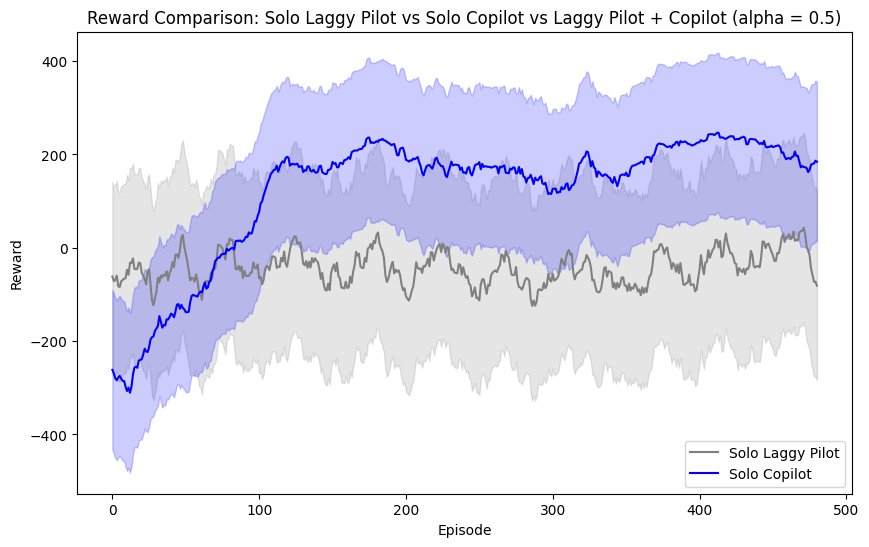

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os

# Helper functions for moving average and stats calculation
def moving_avg(d, n=20):
    if len(d) == 0:
        return np.array([np.nan])
    s = np.concatenate((np.zeros(1), np.cumsum(d).astype(float)))
    return (s[n:] - s[:-n]) / n

def plot_config(data, label, color, fill=True, smooth_win=20):
    if len(data) == 0:
        print(f"Skipping {label}: Data is empty.")
        return
    
    smoothed_data = moving_avg(data, smooth_win)
    x = np.arange(len(smoothed_data))
    
    plt.plot(x, smoothed_data, label=label, color=color)
    if fill:
        plt.fill_between(x, smoothed_data - np.std(data), smoothed_data + np.std(data), alpha=0.2, color=color)

# Ensure the data is flattened
def flatten(data):
    if isinstance(data, list):
        flattened = []
        for item in data:
            if isinstance(item, list):
                flattened.extend(item)
            else:
                flattened.append(item)
        return flattened
    return data

# Load the reward data
data_dir = 'data/lunarlander-sim'

# Load reward data for laggy pilot + copilot (alpha = 0.5)
with open(os.path.join(data_dir, 'copilot_with_laggy_alpha_0.5_reward_data.pkl'), 'rb') as f:
    laggy_copilot_rewards_alpha_05 = pickle.load(f)

# Load reward data for solo copilot (noop pilot, alpha = 0)
with open(os.path.join(data_dir, 'copilot_with_noop_alpha_0_reward_data.pkl'), 'rb') as f:
    solo_copilot_rewards_alpha_0 = pickle.load(f)

# Load the pilot evaluations
with open(os.path.join(data_dir, 'pilot_evals.pkl'), 'rb') as f:
    pilot_evals = pickle.load(f)

# Extract rewards for solo laggy pilot
laggy_pilot_rewards = pilot_evals['laggy'][0]  # Assuming rewards are the first element

# Flatten the reward data
laggy_pilot_rewards = flatten(laggy_pilot_rewards)
#laggy_copilot_rewards_alpha_05 = flatten(laggy_copilot_rewards_alpha_05)
solo_copilot_rewards_alpha_0 = flatten(solo_copilot_rewards_alpha_0)

# Plot Rewards for Solo Laggy Pilot, Solo Copilot, and Laggy Pilot + Copilot (alpha = 0.5)
plt.figure(figsize=(10, 6))
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward Comparison: Solo Laggy Pilot vs Solo Copilot vs Laggy Pilot + Copilot (alpha = 0.5)')

# Solo Laggy Pilot
plot_config(laggy_pilot_rewards, 'Solo Laggy Pilot', 'gray')
plot_config(solo_copilot_rewards_alpha_0[:500], 'Solo Copilot', 'blue')
#plot_config(laggy_copilot_rewards_alpha_05, 'Laggy Pilot + Copilot', 'orange')

plt.legend(loc='lower right')
#plt.ylim([-400, 400])
plt.savefig(os.path.join(data_dir, 'reward_comparison.pdf'), bbox_inches='tight')
plt.show()


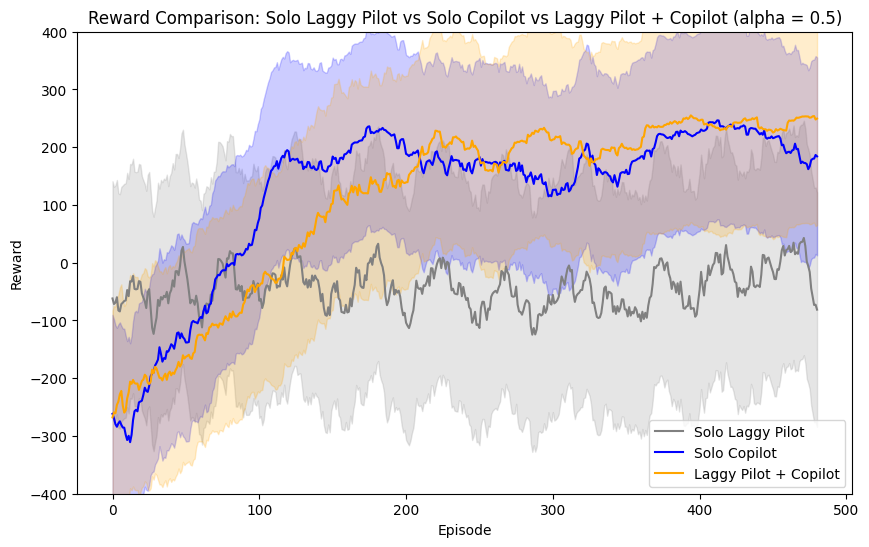

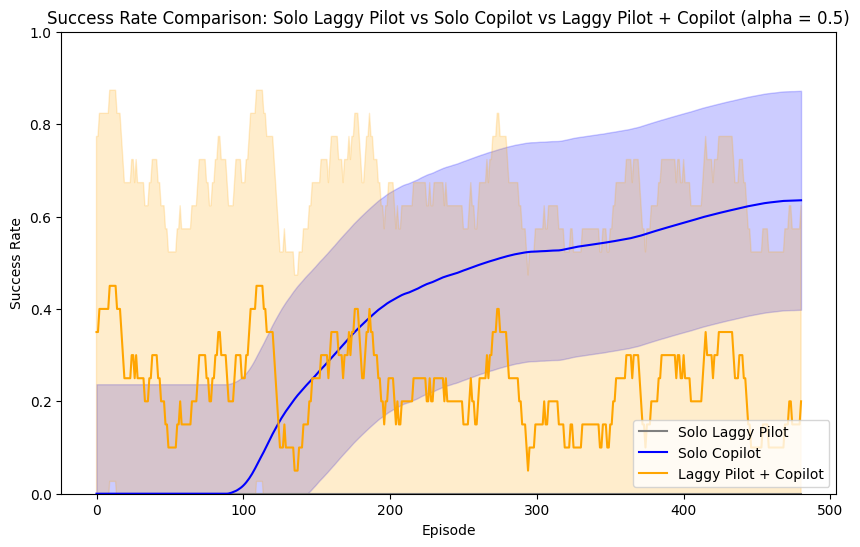

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

# Define helper functions
def moving_avg(data, window_size=20):
    cumsum = np.cumsum(np.insert(data, 0, 0)) 
    return (cumsum[window_size:] - cumsum[:-window_size]) / window_size

def plot_config(data, label, color, fill=True, smooth_win=20):
    if len(data) == 0:
        print(f"Skipping {label}: Data is empty.")
        return
    
    smoothed_data = moving_avg(data, smooth_win)
    x = np.arange(len(smoothed_data))
    
    plt.plot(x, smoothed_data, label=label, color=color)
    if fill:
        plt.fill_between(x, smoothed_data - np.std(data), smoothed_data + np.std(data), alpha=0.2, color=color)

def flatten(data):
    return [item for sublist in data for item in sublist]

# Load reward data
def load_data(file_name):
    with open(os.path.join(data_dir, file_name), 'rb') as f:
        return pickle.load(f)

#laggy_pilot_rewards = flatten(load_data('pilot_evals.pkl')['laggy'][0])
laggy_pilot_rewards = load_data('pilot_evals.pkl')['laggy'][0]
laggy_copilot_rewards_alpha_05 = load_data('copilot_with_laggy_alpha_0.6_reward_data.pkl')
solo_copilot_rewards_alpha_0 = load_data('copilot_with_noop_alpha_0_reward_data.pkl')

# Load success rate data
laggy_copilot_success_alpha_05 = load_data('copilot_with_laggy_alpha_0.5_success_rate.pkl')
solo_copilot_success_alpha_0 = load_data('copilot_with_noop_alpha_0_success_rate.pkl')

# Plot Rewards for Solo Laggy Pilot, Solo Copilot, and Laggy Pilot + Copilot (alpha = 0.5)
plt.figure(figsize=(10, 6))
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward Comparison: Solo Laggy Pilot vs Solo Copilot vs Laggy Pilot + Copilot (alpha = 0.5)')

# Solo Laggy Pilot
plot_config(laggy_pilot_rewards[:500], 'Solo Laggy Pilot', 'gray')
plot_config(solo_copilot_rewards_alpha_0[:500], 'Solo Copilot', 'blue')
plot_config(laggy_copilot_rewards_alpha_05[:500], 'Laggy Pilot + Copilot', 'orange')

plt.legend(loc='lower right')
plt.ylim([-400, 400])
plt.savefig(os.path.join(data_dir, 'reward_comparison_new.pdf'), bbox_inches='tight')
plt.show()

# Plot Success Rates for Solo Laggy Pilot, Solo Copilot, and Laggy Pilot + Copilot (alpha = 0.5)
plt.figure(figsize=(10, 6))
plt.xlabel('Episode')
plt.ylabel('Success Rate')
plt.title('Success Rate Comparison: Solo Laggy Pilot vs Solo Copilot vs Laggy Pilot + Copilot (alpha = 0.5)')

# Solo Laggy Pilot
plot_config(np.zeros(len(laggy_pilot_rewards[:500])), 'Solo Laggy Pilot', 'gray')  # Placeholder for laggy pilot success rate
plot_config(solo_copilot_success_alpha_0[:500], 'Solo Copilot', 'blue')
plot_config(laggy_copilot_success_alpha_05[:500], 'Laggy Pilot + Copilot', 'orange')

plt.legend(loc='lower right')
plt.ylim([0, 1])
plt.savefig(os.path.join(data_dir, 'success_rate_comparison_new.pdf'), bbox_inches='tight')
plt.show()
